In [1]:
# Importing required libraries
import sys
# adding to the path variables the one folder higher (locally, not changing system variables)
sys.path.append("..")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
# import graph objects as "go"
import plotly
import plotly.graph_objs as go
import plotly.express as px



from datetime import datetime

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss

import warnings
warnings.filterwarnings('ignore')

from modeling.config import EXPERIMENT_NAME
TRACKING_URI = open("../.mlflow_uri").read().strip()

In [2]:
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

imb_2019 = pd.read_csv("../data/merged_final_1h.csv", index_col=0, parse_dates=['dt_start_utc'], date_parser=dateparse)

In [3]:
def fill_missing(data):
    data = data.resample('1H').median()
    data = data.interpolate(method='time', limit_direction='both')
    return data

In [4]:
imb_2019.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15336 entries, 2019-01-01 00:00:00 to 2020-09-30 23:00:00
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   windspeed_ms            15336 non-null  float64
 1   epex_da_de_eur_mwh      15336 non-null  float64
 2   solar_mw_fiftyhertz     15336 non-null  float64
 3   solar_mw_tennet         15336 non-null  float64
 4   solar_mw_amprion        15336 non-null  float64
 5   solar_mw_transnetbw     15336 non-null  float64
 6   solar_mw_nrv            15336 non-null  float64
 7   fc_da                   15336 non-null  float64
 8   fc_load_50H             15336 non-null  float64
 9   fc_load_DE              15336 non-null  float64
 10  fc_load_DK              15336 non-null  float64
 11  fc_load_DK1             15336 non-null  float64
 12  fc_load_TTG             15336 non-null  float64
 13  fc_solar_50H            15336 non-null  float64
 14  fc_

In [5]:
imb_2019

windspeed_ms  epex_da_de_eur_mwh  solar_mw_fiftyhertz  \
dt_start_utc                                                                 
2019-01-01 00:00:00       13.7925               10.07                  0.0   
2019-01-01 01:00:00       14.3600               -4.08                  0.0   
2019-01-01 02:00:00       15.0180               -9.91                  0.0   
2019-01-01 03:00:00       14.8220               -7.41                  0.0   
2019-01-01 04:00:00       14.5930              -12.55                  0.0   
...                           ...                 ...                  ...   
2020-09-30 19:00:00        6.1635               49.92                  0.0   
2020-09-30 20:00:00        5.9385               42.79                  0.0   
2020-09-30 21:00:00        6.0630               35.02                  0.0   
2020-09-30 22:00:00        6.2825               34.40                  0.0   
2020-09-30 23:00:00        6.3625               34.00                  0.0   

                     solar_mw_tennet  solar_mw_amprion  solar_mw_transnetbw  \
dt_start_utc                                                                  
2019-01-01 00:00:00             0.00               0.0                  0.0   
2019-01-01 01:00:00             0.00               0.0                  0.0   
2019-01-01 02:00:00             0.00               0.0                  0.0   
2019-01-01 03:00:00             0.00               0.0                  0.0   
2019-01-01 04:00:00             0.00               0.0                  0.0   
...                              ...               ...                  ...   
2020-09-30 19:00:00             0.03               0.0                  0.0   
2020-09-30 20:00:00             0.05               0.0                  0.0   
2020-09-30 21:00:00             0.05               0.0                  0.0   
2020-09-30 22:00:00             0.06               0.0                  0.0   
2020-09-30 23:00:00             0.01               0.0                  0.0   

                     solar_mw_nrv   fc_da  fc_load_50H  fc_load_DE  ...  \
dt_start_utc                                                        ...   
2019-01-01 00:00:00          0.00  29.730       6150.5     41218.5  ...   
2019-01-01 01:00:00          0.00  26.050       6029.0     40139.0  ...   
2019-01-01 02:00:00          0.00  23.760       6057.0     39917.0  ...   
2019-01-01 03:00:00          0.00  20.950       6122.5     40282.0  ...   
2019-01-01 04:00:00          0.00  15.770       6152.0     40528.0  ...   
...                           ...     ...          ...         ...  ...   
2020-09-30 19:00:00          0.03  53.555      11108.5     56709.0  ...   
2020-09-30 20:00:00          0.05  46.200      10454.5     53241.0  ...   
2020-09-30 21:00:00          0.05  40.030       9635.5     49149.0  ...   
2020-09-30 22:00:00          0.06  37.970       9068.0     46540.0  ...   
2020-09-30 23:00:00          0.01  36.020       8696.0     44828.0  ...   

                     offshore_mw_nrv  onshore_mw_fiftyhertz  \
dt_start_utc                                                  
2019-01-01 00:00:00          5684.34                9231.31   
2019-01-01 01:00:00          5334.19               10012.16   
2019-01-01 02:00:00          5278.54               10852.08   
2019-01-01 03:00:00          5160.90               11761.89   
2019-01-01 04:00:00          5001.96               13125.93   
...                              ...                    ...   
2020-09-30 19:00:00          4756.97                 651.60   
2020-09-30 20:00:00          5196.46                 707.77   
2020-09-30 21:00:00          5339.31                 779.20   
2020-09-30 22:00:00          5396.54                 847.60   
2020-09-30 23:00:00          5342.51                1010.84   

                     onshore_mw_tennet  onshore_mw_amprion  \
dt_start_utc                                                 
2019-01-01 00:00:00           11624.89             3039.50

In [509]:
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=imb_2019.index,y=imb_2019['imbalance_price_target'], name='predicted', line=dict(color='blue', width=1)))
  fig.show()

In [ ]:
imb_2019[['imbalance_price_target']]

In [16]:
def train_test_split(df):
    n = int(len(df)*0.7)
    train, test = df.iloc[:n], df.iloc[n:]

    return train,test

In [17]:
train_2019, test_2019 = train_test_split(imb_2019)
#train_2020, test_2020 = train_test_split(imb_2020)

In [10]:
print(train_2019.shape, test_2019.shape)
#print(train_2020.shape, test_2020.shape)

(10735, 38) (4601, 38)


In [14]:
def kpss_test(ts):
    """
    Performs a KPSS test for the null hypothesis of stationarity.
    
        Args:
        ts: 1d time series
        
        Returns:
        Summary of test statistic and critical values
    """
    print ('Results of KPSS Test:')
    kpsstest = kpss(ts, regression='c', nlags='legacy')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

def adf_test(ts):
    """
    Performs a Dickey-Fuller test for the null hypothesis of
    non-stationarity.
    
        Args:
        ts: 1-d time series
    
        Returns:
        Printed test statistic and critical values.
    """
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used',
                                             'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [126]:
print(kpss_test(train_2019[['imbalance_price_target']]))
print('null hypothesis kpss : Stationary data')
print(adf_test(train_2019[['imbalance_price_target']]))
print('null hypothesis adf : Non Stationary data')

Results of KPSS Test:
Test Statistic            1.809928
p-value                   0.010000
Lags Used                39.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
None
null hypothesis kpss : Stationary data
Results of Dickey-Fuller Test:
Test Statistic                -1.196206e+01
p-value                        4.080435e-22
#Lags Used                     3.000000e+01
Number of Observations Used    1.070400e+04
Critical Value (1%)           -3.430961e+00
Critical Value (5%)           -2.861810e+00
Critical Value (10%)          -2.566914e+00
dtype: float64
None
null hypothesis adf : Non Stationary data


kpss and adf results are contradictory one reason for that is the data is not stationary. Lets take a difference with the first lag and check again kpss and adf tests

In [127]:
def take_diff(df):
    diff = df - df.shift(1)
    diff.dropna(inplace=True)

    return diff


In [128]:
diff_train_2019 = take_diff(train_2019[['imbalance_price_target']])

In [129]:
diff_train_2019.head()

imbalance_price_target
dt_start_utc                               
2019-01-01 01:00:00                  -0.270
2019-01-01 02:00:00                  -5.515
2019-01-01 03:00:00                  20.605
2019-01-01 04:00:00                 -16.280
2019-01-01 05:00:00                   1.445

In [130]:
print(kpss_test(diff_train_2019[['imbalance_price_target']]))
print('null hypothesis kpss : Stationary data')
print(adf_test(diff_train_2019[['imbalance_price_target']]))
print('null hypothesis adf : Non Stationary data')

Results of KPSS Test:
Test Statistic            0.005909
p-value                   0.100000
Lags Used                39.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
None
null hypothesis kpss : Stationary data
Results of Dickey-Fuller Test:
Test Statistic                   -24.341268
p-value                            0.000000
#Lags Used                        39.000000
Number of Observations Used    10694.000000
Critical Value (1%)               -3.430962
Critical Value (5%)               -2.861810
Critical Value (10%)              -2.566914
dtype: float64
None
null hypothesis adf : Non Stationary data


We can see now after substracting with its first lag, both kpss and adf tests varify that the data is now stationary. This also indicate the d value in ARIMA should be fix to 1.

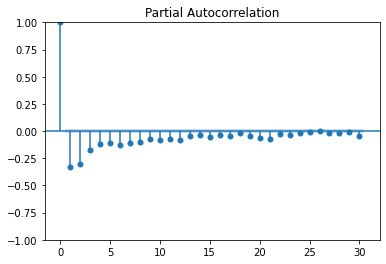

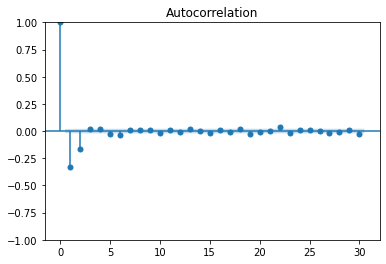

In [131]:
plot_pacf(diff_train_2019, lags=30, alpha=0.05)
plot_acf(diff_train_2019, lags=30, alpha=0.05);

Conclusion : AR (2), MA (2-4?)

In [132]:
p_range = range(1,4)
d_range = [0,1]
q_range = range(2,6)

In [133]:
def best_aic(df, p_range, d_range, q_range):
    aic = []
    for p in p_range:
        for d in d_range:
            for q in q_range:
                order = (p,d,q)
                model = ARIMA(df, order=order)
                model_fit = model.fit()
                aic.append([order, model_fit.aic])
                print(order, model_fit.aic)
    return aic

In [134]:
aic = best_aic(train_2019[['imbalance_price_target']], p_range, d_range, q_range)

(1, 0, 2) 107430.64876292297
(1, 0, 3) 107424.28542198557
(1, 0, 4) 107398.9972283908
(1, 0, 5) 107359.13681472008
(1, 1, 2) 107492.98338836321
(1, 1, 3) 107409.89623452799
(1, 1, 4) 107415.88142493583
(1, 1, 5) 107409.91093855858
(2, 0, 2) 107416.55199340996
(2, 0, 3) 107386.41597966073
(2, 0, 4) 107371.08753842188
(2, 0, 5) 107358.52939700862
(2, 1, 2) 107484.99290250466
(2, 1, 3) 107413.00867169621
(2, 1, 4) 107416.51571968923
(2, 1, 5) 107411.6701462342
(3, 0, 2) 107405.84943056543
(3, 0, 3) 107382.04334827041
(3, 0, 4) 107367.66296420193
(3, 0, 5) 107355.11959278377
(3, 1, 2) 107410.01895129865
(3, 1, 3) 107403.65618518896
(3, 1, 4) 107420.52172644512
(3, 1, 5) 107420.03069908932


best parameters (1, 0, 5) 107359.13681472008 : NOTE that (3,0,5) has slightly less aic value however it is more expensive and the difference is quite less so we considered  (1,0,5) as the best parameter

## Check for seasonality

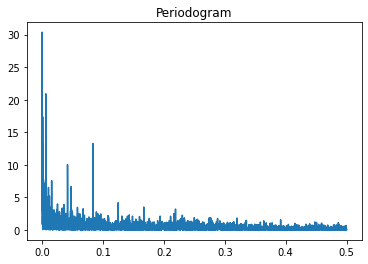

In [149]:
from scipy import signal
# We use for the sampling frequency 1 as we want to
# discover cycles over the original time steps.
f, Pxx = signal.periodogram(imb_2019['imbalance_price_target'], fs = 1, window='hamming', scaling='spectrum')
plt.plot(f, Pxx)
plt.title('Periodogram')
plt.show();

In [150]:
np.argsort(Pxx)[-20:]

array([  52,  730,   18,   42,   17,  239,   27,   86,   10,   14,    5,
        639,   23, 1278,    9,    3,   13,   91,    2,    1])

In [151]:
1/f[np.argsort(Pxx)[-20:]]

array([2.94923077e+02, 2.10082192e+01, 8.52000000e+02, 3.65142857e+02,
       9.02117647e+02, 6.41673640e+01, 5.68000000e+02, 1.78325581e+02,
       1.53360000e+03, 1.09542857e+03, 3.06720000e+03, 2.40000000e+01,
       6.66782609e+02, 1.20000000e+01, 1.70400000e+03, 5.11200000e+03,
       1.17969231e+03, 1.68527473e+02, 7.66800000e+03, 1.53360000e+04])

### list of smallest periods
* 168
* 12
* 24

### Prediction 1h Forecast with only Target variable (Fitting only once)
aic = best_aic(train_2019,(1,0,5))

In [89]:
train_imb = train_2019[['imbalance_price_target']].copy()

In [175]:
model = SARIMAX(train_imb,order=(1,0,5),seasonal_order=(1,0,5,12),enforce_stationarity=False, enforce_invertibility=False,freq='H')
result = model.fit(maxiter=1000,disp=False)

## Checking coefficient for different fitting

In [162]:
#increase train data by adding one additional test data
train_imb2 = pd.concat([train_imb, pd.DataFrame(test_2019[['imbalance_price_target']].iloc[0]).T])
#fit the SARIMA model on this extended data
model2 = SARIMAX(train_imb2,order=(1,0,5),seasonal_order=(1,0,5,12),enforce_stationarity=False, enforce_invertibility=False)
result2 = model2.fit(maxiter=1000,disp=False)
result2.forecast(steps=1)

2020-03-23 08:00:00    11.460595
Freq: H, dtype: float64

In [305]:
#increase train_imb2 data by adding one additional test data
train_imb3 = pd.concat([train_imb2, pd.DataFrame(test_2019[['imbalance_price_target']].iloc[1]).T])
#fit the SARIMA model on this extended data
model3 = SARIMAX(train_imb3,order=(1,0,5),seasonal_order=(1,0,5,12),enforce_stationarity=False, enforce_invertibility=False,)
result3 = model3.fit(maxiter=1000,disp=False)

In [306]:
#create the df from the coefficient obtains from different fit
df_coeff = pd.DataFrame(result.params, index=None)
df_coeff['1'] = result2.params
df_coeff['2'] = result3.params


In [307]:
df_coeff

0            1            2
ar.L1        0.971026     0.970978     0.971451
ma.L1       -0.593035    -0.593038    -0.595382
ma.L2       -0.219731    -0.220589    -0.219743
ma.L3        0.017671     0.017996     0.022236
ma.L4       -0.015535    -0.015320    -0.017837
ma.L5       -0.060319    -0.060163    -0.061286
ar.S.L12     0.997957     0.998045     0.997770
ma.S.L12    -0.998699    -0.999043    -0.997924
ma.S.L24     0.018571     0.018578     0.021214
ma.S.L36    -0.015731    -0.016709    -0.019526
ma.S.L48     0.027049     0.027475     0.030765
ma.S.L60    -0.018271    -0.017762    -0.020796
sigma2    1319.041066  1284.980623  1331.208036

We can see that the coefficient are not much different for different fitting, so we can use the coefficient of the first fitting for all subsequent steps

In [93]:
#for i in range(len(test_2019)):
forecasts_1h = []
for i in range(len(test_2019)):
    forecast_1h = result.forecast(steps=1)
    result = result.extend(pd.DataFrame(test_2019[['imbalance_price_target']].iloc[i]).T)
    print(forecast_1h)
    forecasts_1h.append(forecast_1h)

2020-03-23 07:00:00   -12.570045
Freq: H, dtype: float64
2020-03-23 08:00:00    11.232019
Freq: H, dtype: float64
2020-03-23 09:00:00   -138.229122
Freq: H, dtype: float64
2020-03-23 10:00:00   -23.259405
Freq: H, dtype: float64
2020-03-23 11:00:00   -5.330838
Freq: H, dtype: float64
2020-03-23 12:00:00   -15.85948
Freq: H, dtype: float64
2020-03-23 13:00:00    22.887968
Freq: H, dtype: float64
2020-03-23 14:00:00    23.809746
Freq: H, dtype: float64
2020-03-23 15:00:00   -46.710722
Freq: H, dtype: float64
2020-03-23 16:00:00    2.854918
Freq: H, dtype: float64
2020-03-23 17:00:00    29.005135
Freq: H, dtype: float64
2020-03-23 18:00:00    25.713641
Freq: H, dtype: float64
2020-03-23 19:00:00   -14.652194
Freq: H, dtype: float64
2020-03-23 20:00:00   -44.276465
Freq: H, dtype: float64
2020-03-23 21:00:00    7.947823
Freq: H, dtype: float64
2020-03-23 22:00:00    1.173569
Freq: H, dtype: float64
2020-03-23 23:00:00    7.735673
Freq: H, dtype: float64
2020-03-24    16.452697
Freq: H, dty

In [27]:
def plot_forecast(forecast_df, title_text):
    #creating a dataframe containing actual and predicted values
    #forecast_df = test_df[['imbalance_price_target']]
    #forecast_df['predicted'] = np.array(forecast_list)
   

    #ploting plotly
    plt.figure(figsize=(16, 8))

    fig = go.Figure()

    #forecast_df = forecast_df[(forecast_df.index > '2020-05-06 01:00:00') & (forecast_df.index < '2020-05-22 23:00:00')]
    
    fig.add_trace(go.Scatter(x=forecast_df.index,y=forecast_df['imbalance_price_target'], name='actual', opacity=0.9, line=dict(color='rgb(249, 220, 33)', width=4)))
    fig.add_trace(go.Scatter(x=forecast_df.index,y=forecast_df['predicted'], name='predicted', line=dict(color="rgb(0, 195, 177)", width=4)))
    # Set axes
    fig.update_yaxes(title_text='Imbalance Energy Price')   
    # Set figure title
    fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)','paper_bgcolor': 'rgba(0, 0, 0, 0)',})
    fig.update_layout(title_text=title_text, title_x=0.5)
    fig.show()
    #print out the RMSE
    mse =mean_squared_error(forecast_df['imbalance_price_target'].values, forecast_df['predicted'].values)
    print('rmse = ', np.sqrt(mse));

In [258]:
def create_df(test_df, forecast_list):
    """ creating dataframe to save it as a csv"""
    forecast_df = test_df[['imbalance_price_target']]
    forecast_df['predicted'] = np.array(forecast_list)

    return forecast_df

In [260]:
#creating dataframe and saving it on a csv file
df_forecasts_1h_1f = create_df(test_2019, forecasts_1h)
df_forecasts_1h_1f.to_csv('forecasts_1h_1f_sarima.csv')

In [106]:
forecast_df = test_2019[['imbalance_price_target']]
forecast_df['predicted'] = np.array(forecasts_1h)


In [15]:
!ls ../data/forecasts

forecast_baseline_1h.csv    forecasts_6h_1f_prophet.csv
forecasts_1h_1f_prophet.csv forecasts_6h_1f_sarima.csv
forecasts_1h_1f_sarima.csv  forecasts_6h_2f_sarima.csv
forecasts_1h_2f_sarima.csv  forecasts_6h_6f_prophet.csv
forecasts_1h_6f_sarima.csv  forecasts_6h_6f_sarima.csv


In [21]:
df_forecasts_1h_1f = pd.read_csv('../data/forecasts/forecasts_1h_1f_sarima.csv')

In [18]:
df_forecasts_1h_1f.head()

dt_start_utc  imbalance_price_target   predicted
0  2020-03-23 07:00:00                  56.745  -12.570045
1  2020-03-23 08:00:00                -368.605   11.232019
2  2020-03-23 09:00:00                 -88.885 -138.229122
3  2020-03-23 10:00:00                  85.235  -23.259405
4  2020-03-23 11:00:00                  40.500   -5.330838

In [22]:
def plot_forecast_presentation(forecast_df, title_text):

   

    #ploting plotly
    plt.figure(figsize=(16, 8))

    fig = go.Figure()

    forecast_df = forecast_df[(forecast_df['dt_start_utc'] > '2020-05-06 01:00:00') & (forecast_df['dt_start_utc'] < '2020-05-22 23:00:00')]
    
    fig.add_trace(go.Scatter(x=forecast_df['dt_start_utc'],y=forecast_df['imbalance_price_target'], name='actual', opacity=0.9, line=dict(color='rgb(249, 220, 33)', width=4)))
    fig.add_trace(go.Scatter(x=forecast_df['dt_start_utc'],y=forecast_df['predicted'], name='predicted', line=dict(color="rgb(0, 195, 177)", width=4)))
    # Set axes
    fig.update_yaxes(title_text='Imbalance Energy Price')   
    # Set figure title
    fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)','paper_bgcolor': 'rgba(0, 0, 0, 0)',})
    fig.update_layout(title_text=title_text, title_x=0.5)
    fig.show()

In [28]:
plot_forecast(df_forecasts_1h_1f,'')

rmse =  50.22053177819132


<Figure size 1152x576 with 0 Axes>

In [24]:
plot_forecast_presentation(df_forecasts_1h_1f,'')

<Figure size 1152x576 with 0 Axes>

In [35]:
df_forecasts_1h_1f

dt_start_utc  imbalance_price_target   predicted
0     2020-03-23 07:00:00                  56.745  -12.570045
1     2020-03-23 08:00:00                -368.605   11.232019
2     2020-03-23 09:00:00                 -88.885 -138.229122
3     2020-03-23 10:00:00                  85.235  -23.259405
4     2020-03-23 11:00:00                  40.500   -5.330838
...                   ...                     ...         ...
4596  2020-09-30 19:00:00                  16.450   32.323017
4597  2020-09-30 20:00:00                  26.050   34.400446
4598  2020-09-30 21:00:00                  56.265   33.230054
4599  2020-09-30 22:00:00                  41.335   36.451522
4600  2020-09-30 23:00:00                  29.340   37.627467

[4601 rows x 3 columns]

In [6]:
plot_forecast(test_2019, forecasts_1h, '')

NameError: name 'test_2019' is not defined

In [43]:
def get_forecast_classification(forecast_df):
    # create dataframe of true and predicted values for  5 classes
    #forecast_df = test_2019[['imbalance_price_target']].iloc[:len(forecast),:]
    #forecast_df['price_pred'] = np.array(forecast)
    forecast_df['class_act_5c'] = forecast_df['imbalance_price_target'].apply(lambda x: 0 if x < -100 else(1 if x < -5 else(2 if x <= 5 else(3 if x <= 100 else 4))))
    forecast_df['class_pred_5c'] = forecast_df['predicted'].apply(lambda x: 0 if x < -100 else(1 if x < -5 else(2 if x <= 5 else(3 if x <= 100 else 4))))
    return forecast_df

In [44]:
df_forecasts_1h_1f_classification = get_forecast_classification(df_forecasts_1h_1f)

In [38]:
df_forecasts_1h_1f_classification.head()

dt_start_utc  imbalance_price_target   predicted  class_act_5c  \
0  2020-03-23 07:00:00                  56.745  -12.570045             3   
1  2020-03-23 08:00:00                -368.605   11.232019             0   
2  2020-03-23 09:00:00                 -88.885 -138.229122             1   
3  2020-03-23 10:00:00                  85.235  -23.259405             3   
4  2020-03-23 11:00:00                  40.500   -5.330838             3   

   class_pred_5c  
0              1  
1              3  
2              0  
3              1  
4              1

In [41]:
def classification_summary(forecast_df):
    cm2 = confusion_matrix(forecast_df['class_act_2c'], forecast_df['class_pred_2c'])
    cm5 = confusion_matrix(forecast_df['class_act_5c'], forecast_df['class_pred_5c'])
    fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,5))
    fig.suptitle('---Confusion matrices---')
    axes[0].set_title('2 class - classification')
    axes[1].set_title('5 class - classification')
    sns.heatmap(ax=axes[0], data=cm2, annot=True, fmt='g')
    sns.heatmap(ax=axes[1], data=cm5, annot=True, fmt='g')
    print('Classification report')
    print(classification_report(forecast_df['class_act_2c'], forecast_df['class_pred_2c']))
    print(classification_report(forecast_df['class_act_5c'], forecast_df['class_pred_5c']))

In [46]:
def classification_accuracy(df, column_name):
    accuracy_all=[]
    for i in range(5):
        sum = (df[(df['class_act_5c'] == i) & (df['class_pred_5c'] == i)]).count()[0]
        accuracy = sum/len(df[df['class_act_5c'] == i])
        accuracy_all.append(np.round(accuracy*100,1))
    accuracy_all = pd.DataFrame(accuracy_all, columns=[column_name])
    return accuracy_all

In [50]:
def plot_classification(df, title_text):
    fig = px.bar(y=df.index, x=df.iloc[:,0], orientation='h', text=df.iloc[:,0],labels={
            "x": "", #Accuracy (%)",
            "y": "",#"Imbalance Energy Price"
                    } )#, title="Univariate SARIMA 1 Hour Forecast")
    fig.update_traces( textposition='outside')
    fig.update_traces(marker_color="rgb(0, 195, 177)")
    fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)','paper_bgcolor': 'rgba(0, 0, 0, 0)',})
    fig.update_layout(
        yaxis = dict(
            tickmode = 'array',
            tickvals = [0, 1, 2, 3, 4],
            ticktext=['', '', '', '', '']
            #ticktext = ['extreme negative', 'low negative', 'close to 0', 'low positive', 'extreme positive']
        ), title_x=0.5, width=600,#title_text=title_text, 
    height=400
    )
    

    fig.show()

In [47]:
accuracy_1h_1f = classification_accuracy(df_forecasts_1h_1f_classification, 'acc_1h_1f_sarima')

In [48]:
accuracy_1h_1f

acc_1h_1f_sarima
0               2.4
1              25.9
2               9.0
3              93.0
4              10.2

In [147]:
accuracy_1h_1f['acc_1h_1f_sarima'].mean()

28.1

In [51]:
plot_classification(accuracy_1h_1f,'')

In [183]:
#for i in range(len(test_2019)):
#forecasts_1h_with_fitting = []
#forecast_1h = result.forecast(steps=1)
#print(forecast_1h)
#forecasts_1h_with_fitting.append(forecast_1h)
#del model
#del result
#for i in range(len(test_2019)-1):
 #   train_imb_fit = pd.concat([train_imb_fit, pd.DataFrame(test_imb_fit.iloc[i]).T])
 #   model = SARIMAX(train_imb_fit,order=(1,0,5),seasonal_order=(1,0,5,12),enforce_stationarity=False, enforce_invertibility=False)
 #   result = model.fit(maxiter=1000,disp=False)
  #  forecast_1h = result.forecast(steps=1)
  #  print(forecast_1h)
  #  forecasts_1h_with_fitting.append(forecast_1h)
  #  del model
  #  del result

## 6 hour focecast

In [185]:
model_6h = SARIMAX(train_imb,order=(1,0,5),seasonal_order=(1,0,5,12),enforce_stationarity=False, enforce_invertibility=False,freq='H')
result_6h = model_6h.fit(maxiter=1000,disp=False)

In [187]:
forecasts_6h = []
for i in range(0,len(test_2019),6):
    forecast_6h = result_6h.forecast(steps=6)
    result_6h = result_6h.extend(pd.DataFrame(test_2019[['imbalance_price_target']].iloc[i:i+6]))
    print(forecast_6h)
    forecasts_6h.append(forecast_6h.values)

2020-03-23 07:00:00   -12.570045
2020-03-23 08:00:00   -14.955286
2020-03-23 09:00:00    -4.908962
2020-03-23 10:00:00     2.794765
2020-03-23 11:00:00    -2.444281
2020-03-23 12:00:00    -9.007842
Freq: H, Name: predicted_mean, dtype: float64
2020-03-23 13:00:00    22.887968
2020-03-23 14:00:00    12.841411
2020-03-23 15:00:00     3.151813
2020-03-23 16:00:00     8.113497
2020-03-23 17:00:00     9.458297
2020-03-23 18:00:00    14.823853
Freq: H, Name: predicted_mean, dtype: float64
2020-03-23 19:00:00   -14.652194
2020-03-23 20:00:00     0.979508
2020-03-23 21:00:00    -1.192324
2020-03-23 22:00:00    -1.962569
2020-03-23 23:00:00    -2.200921
2020-03-24 00:00:00    -7.738298
Freq: H, Name: predicted_mean, dtype: float64
2020-03-24 01:00:00     8.757592
2020-03-24 02:00:00     9.851016
2020-03-24 03:00:00     6.957802
2020-03-24 04:00:00    10.062692
2020-03-24 05:00:00    12.368211
2020-03-24 06:00:00    12.933776
Freq: H, Name: predicted_mean, dtype: float64
2020-03-24 07:00:00    -

In [188]:
forecasts_6h = np.array(forecasts_6h).reshape(-1,1)
forecasts_6h = forecasts_6h[:-1]

In [263]:
df_forecasts_6h_1f = create_df(test_2019, forecasts_6h)

In [264]:
df_forecasts_6h_1f.to_csv('forecasts_6h_1f_sarima.csv')

In [52]:
df_forecasts_6h_1f = pd.read_csv('../data/forecasts/forecasts_6h_1f_sarima.csv')

In [53]:
plot_forecast(df_forecasts_6h_1f, '')

rmse =  53.365573942154114


<Figure size 1152x576 with 0 Axes>

In [54]:
df_forecast_6h_1f = get_forecast_classification(df_forecasts_6h_1f)
accuracy_6h_1f = classification_accuracy(df_forecast_6h_1f, 'acc_6h_1f_sarima')
plot_classification(accuracy_6h_1f,'')


## 12 Hour Forecast

In [55]:
model12 = SARIMAX(train_imb,order=(1,0,5),seasonal_order=(1,0,5,24),enforce_stationarity=False, enforce_invertibility=False,freq='H')
result12 = model.fit(maxiter=1000,disp=False)

NameError: name 'train_imb' is not defined

In [516]:
result12 = result24

In [521]:
forecasts_12h = []
for i in range(0,len(test_2019),12):
    forecast_12h = result12.forecast(steps=12)
    print(forecast_12h)
    result12 = result12.extend(pd.DataFrame(test_2019[['imbalance_price_target']].iloc[i:i+12]).values)
    forecasts_12h.append(forecast_12h.values)

10763     6.169708
10764     1.098495
10765     4.769785
10766     3.532003
10767     1.163030
10768    14.384568
10769    15.529630
10770    14.476175
10771     4.055821
10772    -4.013449
10773     8.053626
10774    12.530337
Name: predicted_mean, dtype: float64
10775    -8.487987
10776    -7.281195
10777    -2.645397
10778    -2.742577
10779     1.065945
10780    10.806680
10781     8.950196
10782     6.927830
10783     1.673194
10784   -10.569382
10785     5.033126
10786    10.569454
Name: predicted_mean, dtype: float64
10787    -5.287488
10788   -20.512632
10789    -2.848725
10790     2.044767
10791     4.325934
10792    14.558207
10793    15.417908
10794    12.385833
10795     7.514317
10796   -10.322186
10797     5.746013
10798    12.596731
Name: predicted_mean, dtype: float64
10799     2.814735
10800     3.761304
10801    10.459540
10802     4.574041
10803    10.136953
10804    20.988964
10805    21.314939
10806    17.822787
10807     8.426337
10808     4.399429
10809    13.957

In [ ]:
forecasts_12h = np.array(forecasts_12h).reshape(-1,1)

In [ ]:
forecasts_12h.shape

(4608, 1)

In [ ]:
test_2019.shape

(4601, 38)

In [ ]:
forecasts_12h = forecasts_12h[:-7]

In [ ]:
df_forecasts_12h_1f = create_df(test_2019, forecasts_12h)

In [531]:
df_forecasts_12h_1f.to_csv('forecasts_12h_1f_sarima.csv')

In [56]:
df_forecasts_12h_1f = pd.read_csv('../data/forecasts/forecasts_12h_1f_sarima.csv')

In [57]:
plot_forecast_presentation(df_forecasts_12h_1f, '')

<Figure size 1152x576 with 0 Axes>

In [58]:
df_forecast_12h_1f = get_forecast_classification(df_forecasts_12h_1f)
accuracy_12h_1f = classification_accuracy(df_forecast_12h_1f, 'acc_12h_1f_sarima')
plot_classification(accuracy_12h_1f,'')

In [59]:
accuracy_12h_1f

acc_12h_1f_sarima
0                0.0
1                5.5
2                7.1
3               94.2
4                3.2

In [60]:
accuracy_1h_6h_12h_1f = pd.concat([accuracy_1h_1f, accuracy_6h_1f, accuracy_12h_1f], axis=1)

In [61]:
accuracy_1h_6h_12h_1f

acc_1h_1f_sarima  acc_6h_1f_sarima  acc_12h_1f_sarima
0               2.4               2.4                0.0
1              25.9              12.1                5.5
2               9.0               7.1                7.1
3              93.0              94.0               94.2
4              10.2               4.2                3.2

In [149]:
accuracy_1h_6h_12h_1f['acc_1h_1f_sarima'].mean()

28.1

In [65]:
def plot_group_data2(df, title_text):

    fig = go.Figure(data=[
    go.Bar(name='12 Hour Forecast', y=df.index, x=df.iloc[:,2], orientation='h', text=df.iloc[:,2], marker=dict(color='rgb(14, 42, 71)')),
    go.Bar(name='6 Hour Forecast', y=df.index, x=df.iloc[:,1], orientation='h', text=df.iloc[:,1], marker=dict(color='rgb(60, 120, 216)')),
    go.Bar(name='1 Hour Forecast', y=df.index, x=df.iloc[:,0], orientation='h', text=df.iloc[:,0], marker=dict(color='rgb(46, 192, 104)')) 
    ])
    fig.update_traces( textposition='outside')
    #fig.update_xaxes(title_text='Accuracy (%)')
    fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)','paper_bgcolor': 'rgba(0, 0, 0, 0)',})
    fig.update_layout(
        yaxis = dict(
            tickmode = 'array',
            tickvals = [0, 1, 2, 3, 4],
            ticktext = ['', '', '', '', ''],
            #ticktext = ['high negative', 'low negative', 'close to 0', 'low positive', 'high positive'],
        ), title_text=title_text, title_x=0.5, legend={'traceorder':'normal'}
    )
    fig.update_layout(legend_traceorder="reversed", width=600,
    height=500)
    fig.show()

In [62]:
accuracy_1h_6h_12h_1f

acc_1h_1f_sarima  acc_6h_1f_sarima  acc_12h_1f_sarima
0               2.4               2.4                0.0
1              25.9              12.1                5.5
2               9.0               7.1                7.1
3              93.0              94.0               94.2
4              10.2               4.2                3.2

In [156]:
accuracy_1h_6h_12h_1f['acc_12h_1f_sarima'].mean()

22.0

In [66]:
plot_group_data2(accuracy_1h_6h_12h_1f, '')

## Predicting 1h ahead with top 6 features 

In [208]:
model_6f = SARIMAX(train_imb,order=(1,0,5),seasonal_order=(1,0,5,12),exog = train_2019[['fc_da', 'fc_load_DE', 'windspeed_ms', 'fc_onshore_DE', 'fc_offshore_DE']], enforce_stationarity=False, enforce_invertibility=False,freq='H')
result_6f = model_6f.fit(maxiter=1000,disp=False)

In [236]:
#for i in range(len(test_2019)):
forecasts_6f_1h = []
forecast_1h = result_6f.forecast(steps=1, exog = train_2019[['fc_da', 'fc_load_DE', 'windspeed_ms', 'fc_onshore_DE', 'fc_offshore_DE']].iloc[-1])
forecasts_6f_1h.append(forecast_1h)
print(forecast_1h)
for i in range(len(test_2019)-1):
    result_6f = result_6f.extend(endog = pd.DataFrame(test_2019[['imbalance_price_target']].iloc[i]).T.values, exog = pd.DataFrame(test_2019[['fc_da', 'fc_load_DE', 'windspeed_ms', 'fc_onshore_DE', 'fc_offshore_DE']].iloc[i]).T.values)
    forecast_1h = result_6f.forecast(steps=1, exog = test_2019[['fc_da', 'fc_load_DE', 'windspeed_ms', 'fc_onshore_DE', 'fc_offshore_DE']].iloc[i])
    print(forecast_1h)
    forecasts_6f_1h.append(forecast_1h)

2020-03-23 07:00:00   -7.259175
Freq: H, dtype: float64
2020-03-23 08:00:00    17.210983
Freq: H, dtype: float64
2020-03-23 09:00:00   -123.006293
Freq: H, dtype: float64
2020-03-23 10:00:00   -11.378895
Freq: H, dtype: float64
2020-03-23 11:00:00    5.041364
Freq: H, dtype: float64
2020-03-23 12:00:00    3.450242
Freq: H, dtype: float64
2020-03-23 13:00:00    26.153439
Freq: H, dtype: float64
2020-03-23 14:00:00    27.268682
Freq: H, dtype: float64
2020-03-23 15:00:00   -38.186865
Freq: H, dtype: float64
2020-03-23 16:00:00    10.838213
Freq: H, dtype: float64
2020-03-23 17:00:00    27.71306
Freq: H, dtype: float64
2020-03-23 18:00:00    39.773433
Freq: H, dtype: float64
2020-03-23 19:00:00    0.588799
Freq: H, dtype: float64
2020-03-23 20:00:00   -55.846575
Freq: H, dtype: float64
2020-03-23 21:00:00    14.470105
Freq: H, dtype: float64
2020-03-23 22:00:00    9.896446
Freq: H, dtype: float64
2020-03-23 23:00:00    10.955
Freq: H, dtype: float64
2020-03-24    25.066283
Freq: H, dtype:

In [271]:
df_forecasts_1h_6f = create_df(test_2019, forecasts_6f_1h)

In [272]:
df_forecasts_1h_6f.to_csv('forecasts_1h_6f_sarima.csv')

In [33]:
df_forecasts_1h_6f = pd.read_csv('../data/forecasts/forecasts_1h_6f_sarima.csv')

In [34]:
plot_forecast_presentation(df_forecasts_1h_6f, '')

<Figure size 1152x576 with 0 Axes>

In [62]:
df_forecast_1h_6f = get_forecast_classification(df_forecasts_1h_6f)
accuracy_1h_6f = classification_accuracy(df_forecast_1h_6f , 'acc_1h_6f_sarima')
plot_classification(accuracy_1h_6f,'')

In [63]:
accuracy_1h = pd.concat([accuracy_1h_1f, accuracy_1h_6f], axis=1)

In [42]:
accuracy_baseline = pd.read_csv('accuracy_baseline_1h_1f.csv')

In [655]:
accuracy_baseline = accuracy_baseline[['acc_baseline']]

In [656]:
accuracy_baseline

acc_baseline
0           7.3
1          42.9
2          20.8
3          81.7
4          32.9

In [64]:
accuracy_1h_baseline = pd.concat([accuracy_baseline, accuracy_1h], axis=1)

In [138]:
accuracy_1h_baseline

Unnamed: 0  acc_baseline  acc_1h_1f_sarima  acc_1h_6f_sarima
0           0           7.3               2.4               2.4
1           1          42.9              25.9              25.5
2           2          20.8               9.0               8.3
3           3          81.7              93.0              93.5
4           4          32.9              10.2               9.3

In [153]:
accuracy_1h_baseline['acc_1h_1f_sarima'].mean()

28.1

In [139]:
accuracy_1h_baseline.drop('Unnamed: 0', inplace=True, axis=1)

In [129]:
def plot_group_data(df, title_text):

    fig = go.Figure(data=[
    go.Bar(name='Multivariate', y=df.index, x=df.iloc[:,2], orientation='h', text=df.iloc[:,2], marker=dict(color='rgb(249, 220, 33)')),
    go.Bar(name='Univariate', y=df.index, x=df.iloc[:,1], orientation='h', text=df.iloc[:,1], marker=dict(color='rgb(0, 195, 177)')),
    
    go.Bar(name='Baseline', y=df.index, x=df.iloc[:,0], orientation='h', text=df.iloc[:,0], marker=dict(color='rgb(168, 209, 61)')) 
    ])
    fig.update_traces( textposition='outside')
    #fig.update_xaxes(title_text='Accuracy (%')
    fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)','paper_bgcolor': 'rgba(0, 0, 0, 0)',})
    fig.update_layout(
        yaxis = dict(
            tickmode = 'array',
            tickvals = [0, 1, 2, 3, 4],
            ticktext=['', '', '', '', '']
            #ticktext = ['high negative', 'low negative', 'close to 0', 'low positive', 'high positive']
        ), title_text=title_text, title_x=0.5, legend={'traceorder':'normal'}#, textfont_size=14
    )
    fig.update_layout(legend_traceorder="reversed",), width=600,
    height=500

    fig.show()

In [140]:
plot_group_data(accuracy_1h_baseline, '')

## 5 features forecast 6h

In [244]:
model_6h_6f = SARIMAX(train_imb,order=(1,0,5),seasonal_order=(1,0,5,12), exog = train_2019[['fc_da','fc_load_DE', 'windspeed_ms', 'fc_onshore_DE', 'fc_offshore_DE']], enforce_stationarity=False, enforce_invertibility=False,freq='H')
result_6h_6f = model_6h_6f.fit(maxiter=1000,disp=False)

In [254]:
#for i in range(len(test_2019)):
forecasts_6h_6f = []
forecast_6h = result_6h_6f.forecast(steps=6, exog = train_2019[['fc_da','fc_load_DE', 'windspeed_ms', 'fc_onshore_DE', 'fc_offshore_DE']].tail(6))
print(forecast_6h)
forecasts_6h_6f.append(forecast_6h)
for i in range(0,len(test_2019)-6,6):
    result_6h_6f = result_6h_6f.extend(endog = pd.DataFrame(test_2019[['imbalance_price_target']].iloc[i:i+6]), exog = pd.DataFrame(test_2019[['fc_da','fc_load_DE', 'windspeed_ms', 'fc_onshore_DE', 'fc_offshore_DE']].iloc[i:i+6]))
    forecast_6h = result_6h_6f.forecast(steps=6, exog = test_2019[['fc_da','fc_load_DE', 'windspeed_ms', 'fc_onshore_DE', 'fc_offshore_DE']].iloc[i:i+6])
    print(forecast_6h)
    forecasts_6h_6f.append(forecast_6h)

2020-03-23 07:00:00   -26.445700
2020-03-23 08:00:00   -26.672153
2020-03-23 09:00:00   -11.725320
2020-03-23 10:00:00     4.440582
2020-03-23 11:00:00     9.428234
2020-03-23 12:00:00    19.811630
Freq: H, Name: predicted_mean, dtype: float64
2020-03-23 13:00:00    37.120523
2020-03-23 14:00:00    25.182767
2020-03-23 15:00:00    10.784330
2020-03-23 16:00:00    13.682596
2020-03-23 17:00:00     3.080080
2020-03-23 18:00:00    18.458289
Freq: H, Name: predicted_mean, dtype: float64
2020-03-23 19:00:00   -15.614518
2020-03-23 20:00:00   -16.712405
2020-03-23 21:00:00    -1.886737
2020-03-23 22:00:00    11.883418
2020-03-23 23:00:00    17.279477
2020-03-24 00:00:00    23.742688
Freq: H, Name: predicted_mean, dtype: float64
2020-03-24 01:00:00    19.930588
2020-03-24 02:00:00    10.385027
2020-03-24 03:00:00    10.966478
2020-03-24 04:00:00    13.550810
2020-03-24 05:00:00     2.845994
2020-03-24 06:00:00     0.070812
Freq: H, Name: predicted_mean, dtype: float64
2020-03-24 07:00:00   -1

In [255]:
forecasts_6h_6f = np.array(forecasts_6h_6f).reshape(-1,1)
print(forecasts_6h_6f.shape)

(4602, 1)


In [256]:
forecasts_6h_6f = forecasts_6h_6f[:-1]

In [ ]:
forecasts_12h = np.array(forecasts_12h).reshape(-1,1)

In [ ]:
forecasts_12h.shape

(4608, 1)

In [ ]:
test_2019.shape

(4601, 38)

In [ ]:
forecasts_12h = forecasts_12h[:-7]

In [ ]:
df_forecasts_12h_1f = create_df(test_2019, forecasts_12h)

In [273]:
df_forecasts_6h_6f = create_df(test_2019, forecasts_6h_6f)
df_forecasts_6h_6f.to_csv('forecasts_6h_6f_sarima.csv')

In [35]:
df_forecasts_6h_6f = pd.read_csv('../data/forecasts/forecasts_6h_6f_sarima.csv')

In [37]:
plot_forecast_presentation(df_forecasts_6h_6f, '')

<Figure size 1152x576 with 0 Axes>

In [81]:
df_forecast_6h_6f = get_forecast_classification(df_forecasts_6h_6f)
accuracy_6h_6f = classification_accuracy(df_forecasts_6h_6f, 'acc_6h_6f')
plot_classification(accuracy_6h_6f,'')

In [82]:
accuracy_6h = pd.concat([accuracy_6h_1f, accuracy_6h_6f], axis=1)

In [83]:
accuracy_6h

acc_6h_1f_sarima  acc_6h_6f
0               2.4        2.4
1              12.1       11.6
2               7.1        6.8
3              94.0       93.9
4               4.2        2.3

NameError: name 'accuracy_12h_1f' is not defined

In [73]:
accuracy_1h_6h_12h_1f

NameError: name 'accuracy_1h_6h_12h_1f' is not defined

In [72]:
plot_group_data2(accuracy_1h_6h_12h_1f, '')

NameError: name 'accuracy_1h_6h_12h_1f' is not defined

## 12 Hours Forecasts

In [534]:
model_12h_6f = SARIMAX(train_imb,order=(1,0,5),seasonal_order=(1,0,5,12), exog = train_2019[['fc_da','fc_load_DE', 'windspeed_ms', 'fc_onshore_DE', 'fc_offshore_DE']], enforce_stationarity=False, enforce_invertibility=False,freq='H')
result_12h_6f = model_12h_6f.fit(maxiter=1000,disp=False)

In [ ]:
result_12h_6f_copy = result_12h_6f

In [535]:
#for i in range(len(test_2019)):
forecasts_12h_6f = []
forecast_12h = result_12h_6f.forecast(steps=12, exog = train_2019[['fc_da','fc_load_DE', 'windspeed_ms', 'fc_onshore_DE', 'fc_offshore_DE']].tail(12))
print(forecast_12h)
forecasts_12h_6f.append(forecast_12h)
for i in range(0,len(test_2019)-12,12):
    result_12h_6f = result_12h_6f.extend(endog = pd.DataFrame(test_2019[['imbalance_price_target']].iloc[i:i+12]), exog = pd.DataFrame(test_2019[['fc_da','fc_load_DE', 'windspeed_ms', 'fc_onshore_DE', 'fc_offshore_DE']].iloc[i:i+12]))
    forecast_12h = result_12h_6f.forecast(steps=12, exog = test_2019[['fc_da','fc_load_DE', 'windspeed_ms', 'fc_onshore_DE', 'fc_offshore_DE']].iloc[i:i+12])
    print(forecast_12h)
    forecasts_12h_6f.append(forecast_12h)

2020-03-23 07:00:00   -14.549646
2020-03-23 08:00:00   -16.574624
2020-03-23 09:00:00    -1.985749
2020-03-23 10:00:00     3.897867
2020-03-23 11:00:00    -3.254983
2020-03-23 12:00:00     1.845323
2020-03-23 13:00:00    -0.148861
2020-03-23 14:00:00     0.425938
2020-03-23 15:00:00    -1.406004
2020-03-23 16:00:00    11.506863
2020-03-23 17:00:00    12.427392
2020-03-23 18:00:00    31.750118
Freq: H, Name: predicted_mean, dtype: float64
2020-03-23 19:00:00    -5.628571
2020-03-23 20:00:00   -12.359645
2020-03-23 21:00:00    -5.093129
2020-03-23 22:00:00     3.182993
2020-03-23 23:00:00     1.325241
2020-03-24 00:00:00     6.558234
2020-03-24 01:00:00     9.532082
2020-03-24 02:00:00     3.948526
2020-03-24 03:00:00    10.256949
2020-03-24 04:00:00    23.294371
2020-03-24 05:00:00    21.728157
2020-03-24 06:00:00    22.589445
Freq: H, Name: predicted_mean, dtype: float64
2020-03-24 07:00:00     0.058774
2020-03-24 08:00:00   -13.562202
2020-03-24 09:00:00     2.201831
2020-03-24 10:00:

In [537]:
np.array(forecasts_12h_6f).shape

(384, 12)

In [538]:
forecasts_12h_6f = np.array(forecasts_12h_6f).reshape(-1,1)

In [539]:
forecasts_12h_6f.shape

(4608, 1)

In [540]:
forecasts_12h_6f = forecasts_12h_6f[:-7]

In [542]:
df_forecasts_12h_6f = create_df(test_2019, forecasts_12h_6f)

In [543]:

df_forecasts_12h_6f.to_csv('forecasts_12h_6f_sarima.csv')

In [38]:
df_forecasts_12h_6f = pd.read_csv('../data/forecasts/forecasts_12h_6f_sarima.csv')

In [39]:
plot_forecast_presentation(df_forecasts_12h_6f, '')

<Figure size 1152x576 with 0 Axes>

In [86]:
df_forecast_12h_6f = get_forecast_classification(df_forecasts_12h_6f)
accuracy_12h_6f = classification_accuracy(df_forecast_12h_6f, 'acc_12h_6f')
plot_classification(accuracy_12h_6f,'')

In [87]:
accuracy_1h_6h_12h_1f = pd.concat([accuracy_1h_1f, accuracy_6h_1f, accuracy_12h_1f], axis=1)

NameError: name 'accuracy_12h_1f' is not defined

## Prophet Files

In [460]:
 !ls -alrst data/forecasts
 

ls: data/forecasts: No such file or directory


In [472]:
df_prophet_1h_1f = pd.read_csv('../data/forecasts/forecasts_1h_1f_prophet.csv')
df_prophet_6h_1f = pd.read_csv('../data/forecasts/forecasts_6h_1f_prophet.csv')
df_prophet_6h_6f = pd.read_csv('../data/forecasts/forecasts_6h_6f_prophet.csv')

In [475]:
df_prophet_1h_1f = df_prophet_1h_1f[['ds', 'y', 'pred_1h_uni' ]]

In [477]:
df_prophet_1h_1f.shape

(4601, 3)

In [478]:
df_prophet_1h_1f.dropna(inplace=True)

In [480]:
df_prophet_1h_1f.head()

ds        y  pred_1h_uni
0  2020-03-23 07:00:00   56.745    31.661674
1  2020-03-23 08:00:00 -368.605    32.978958
2  2020-03-23 09:00:00  -88.885    32.901179
3  2020-03-23 10:00:00   85.235    31.620669
4  2020-03-23 11:00:00   40.500    32.096781

In [505]:
def plot_forecast_regression(forecast_df):
    #creating a dataframe containing actual and predicted value

    #ploting plotly
    plt.figure(figsize=(16, 8))

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=forecast_df.index,y=forecast_df.iloc[:,2], name='predicted', line=dict(color='blue', width=4)))
    fig.add_trace(go.Scatter(x=forecast_df.index,y=forecast_df.iloc[:,1], name='actual', opacity=0.5, line=dict(color='red', width=4)))
    fig.show()
    #print out the RMSE
    mse =mean_squared_error(forecast_df.iloc[:,1].values, forecast_df.iloc[:,2].values)
    print('rmse = ', np.sqrt(mse));

In [506]:
plot_forecast_regression(df_prophet_1h_1f)

rmse =  69.8816428255095


<Figure size 1152x576 with 0 Axes>

In [499]:
df_forecasts_1h_1f_prophet = get_forecast_classification(df_prophet_1h_1f.iloc[:,2])

In [500]:
accuracy_1h_1f_prophet = classification_accuracy(df_forecasts_1h_1f_prophet, 'acc_1h_1f_prophet')
plot_classification(accuracy_1h_1f_prophet,'Univariate Prophet 1 Hour Forecast')

## SARIMA Considering 24 hours seasonality 

In [510]:
model12 = SARIMAX(train_imb,order=(1,0,5),seasonal_order=(1,0,5,24),enforce_stationarity=False, enforce_invertibility=False,freq='H')
result12 = model.fit(maxiter=1000,disp=False)

In [513]:
result12 = result24

In [511]:
result24_copy = result24

In [512]:
#for i in range(len(test_2019)):
forecasts_1h_24 = []
for i in range(len(test_2019)):
    forecast_1h = result24.forecast(steps=1)
    result24 = result24.extend(pd.DataFrame(test_2019[['imbalance_price_target']].iloc[i]).T)
    print(forecast_1h)
    forecasts_1h_24.append(forecast_1h)

ValueError: Given `endog` does not have an index that extends the index of the model.

## Plot Univariate 1h (including base line)

In [ ]:
def plot_classification_comparison(df, title_text):

    fig = go.Figure(data=[
    go.Bar(name='Univariate', y=df.index, x=df.iloc[:,0], orientation='h', text=df.iloc[:,0]),
    go.Bar(name='Multivariate', y=df.index, x=df.iloc[:,1], orientation='h', text=df.iloc[:,1]) ])
    fig.update_traces( textposition='outside')
    fig.update_layout(
        yaxis = dict(
            tickmode = 'array',
            tickvals = [0, 1, 2, 3, 4],
            ticktext = ['extreme negative', 'low negative', 'close to 0', 'low positive', 'extreme positive']
        ), title_text=title_text, title_x=0.5
    )

    fig.show()

## WITH forecast_day_ahead feature as additional feature

In [ ]:
model_2f = SARIMAX(train_imb,order=(1,0,5),seasonal_order=(1,0,5,12),exog = train_2019[['fc_da']], enforce_stationarity=False, enforce_invertibility=False,freq='H')
result_2f = model_2f.fit(maxiter=1000,disp=False)

In [ ]:
result_2f_bkup = result_2f

In [ ]:
#for i in range(len(test_2019)):
forecasts_2f_1h = []
forecast_1h = result_2f_bkup.forecast(steps=1, exog = train_2019[['fc_da']].iloc[-1])
forecasts_2f_1h.append(forecast_1h)
for i in range(len(test_2019)):
    result_2f_bkup = result_2f_bkup.extend(endog = pd.DataFrame(test_2019[['imbalance_price_target']].iloc[i]).T.values, exog = pd.DataFrame(test_2019[['fc_da']].iloc[i]).T.values)
    forecast_1h = result_2f_bkup.forecast(steps=1, exog = test_2019[['fc_da']].iloc[i])
    print(forecast_1h)
    forecasts_2f_1h.append(forecast_1h)

2020-03-23 08:00:00    22.325105
Freq: H, dtype: float64
2020-03-23 09:00:00   -126.446038
Freq: H, dtype: float64
2020-03-23 10:00:00   -14.373025
Freq: H, dtype: float64
2020-03-23 11:00:00    3.969542
Freq: H, dtype: float64
2020-03-23 12:00:00   -2.512782
Freq: H, dtype: float64
2020-03-23 13:00:00    23.09985
Freq: H, dtype: float64
2020-03-23 14:00:00    23.774531
Freq: H, dtype: float64
2020-03-23 15:00:00   -38.990409
Freq: H, dtype: float64
2020-03-23 16:00:00    5.339086
Freq: H, dtype: float64
2020-03-23 17:00:00    31.2343
Freq: H, dtype: float64
2020-03-23 18:00:00    33.390958
Freq: H, dtype: float64
2020-03-23 19:00:00    0.878603
Freq: H, dtype: float64
2020-03-23 20:00:00   -37.347475
Freq: H, dtype: float64
2020-03-23 21:00:00    13.485647
Freq: H, dtype: float64
2020-03-23 22:00:00    6.6647
Freq: H, dtype: float64
2020-03-23 23:00:00    12.972962
Freq: H, dtype: float64
2020-03-24    24.380206
Freq: H, dtype: float64
2020-03-24 01:00:00    5.295134
Freq: H, dtype: f

In [ ]:
df_forecasts_2f_1h = create_df(test_2019, forecasts_2f_1h)

In [ ]:
df_forecasts_2f_1h.to_csv('forecasts_1h_2f_sarima.csv')

In [ ]:
len(forecasts_2f_1h)

4602

In [ ]:
forecasts_2f_1h = forecasts_2f_1h[:-1]

In [ ]:
plot_forecast(test_2019, forecasts_2f_1h)

rmse =  50.20358661240648


<Figure size 1152x576 with 0 Axes>

## 6 Hour Forcast with day ahead forecast as additional feature

In [ ]:
model_6h_2f = SARIMAX(train_imb,order=(1,0,5),seasonal_order=(1,0,5,12), exog = train_2019[['fc_da']], enforce_stationarity=False, enforce_invertibility=False,freq='H')
result_6h_2f = model_6h_2f.fit(maxiter=1000,disp=False)

In [ ]:
result_6h_2f_bkup  = result_6h_2f

In [ ]:
train_2019[['fc_da']].tail(6)

fc_da
dt_start_utc              
2020-03-23 01:00:00  19.49
2020-03-23 02:00:00  17.89
2020-03-23 03:00:00  18.07
2020-03-23 04:00:00  23.93
2020-03-23 05:00:00  31.73
2020-03-23 06:00:00  35.78

In [ ]:
train_2019[['fc_da']].iloc[-6:]

fc_da
dt_start_utc              
2020-03-23 01:00:00  19.49
2020-03-23 02:00:00  17.89
2020-03-23 03:00:00  18.07
2020-03-23 04:00:00  23.93
2020-03-23 05:00:00  31.73
2020-03-23 06:00:00  35.78

In [ ]:
result_6h_2f.forecast(steps=6, exog = train_2019[['fc_da']].iloc[-6:])

2020-03-23 07:00:00   -16.106587
2020-03-23 08:00:00   -16.132326
2020-03-23 09:00:00    -8.748934
2020-03-23 10:00:00     5.592666
2020-03-23 11:00:00    12.919313
2020-03-23 12:00:00    18.196726
Freq: H, Name: predicted_mean, dtype: float64

In [ ]:
#for i in range(len(test_2019)):
forecasts_6h_2f = []
forecast_6h = result_6h_2f.forecast(steps=6, exog = train_2019[['fc_da']].iloc[-6:])
print(forecast_6h)
forecasts_6h_2f.append(forecast_6h)
for i in range(0,len(test_2019)-6,6):
    result_6h_2f = result_6h_2f.extend(endog = pd.DataFrame(test_2019[['imbalance_price_target']].iloc[i:i+6]), exog = pd.DataFrame(test_2019[['fc_da']].iloc[i:i+6]))
    forecast_6h = result_6h_2f.forecast(steps=6, exog = test_2019[['fc_da']].iloc[i:i+6])
    print(forecast_6h)
    forecasts_6h_2f.append(forecast_6h)

2020-03-23 07:00:00   -16.106587
2020-03-23 08:00:00   -16.132326
2020-03-23 09:00:00    -8.748934
2020-03-23 10:00:00     5.592666
2020-03-23 11:00:00    12.919313
2020-03-23 12:00:00    18.196726
Freq: H, Name: predicted_mean, dtype: float64
2020-03-23 13:00:00    34.470037
2020-03-23 14:00:00    21.145516
2020-03-23 15:00:00    10.081928
2020-03-23 16:00:00     8.496562
2020-03-23 17:00:00     4.939972
2020-03-23 18:00:00    12.655350
Freq: H, Name: predicted_mean, dtype: float64
2020-03-23 19:00:00   -16.454355
2020-03-23 20:00:00     0.880198
2020-03-23 21:00:00     2.659648
2020-03-23 22:00:00     9.007836
2020-03-23 23:00:00    17.996332
2020-03-24 00:00:00    22.379188
Freq: H, Name: predicted_mean, dtype: float64
2020-03-24 01:00:00    18.156014
2020-03-24 02:00:00    16.642536
2020-03-24 03:00:00    14.984924
2020-03-24 04:00:00    11.900583
2020-03-24 05:00:00     8.279951
2020-03-24 06:00:00     9.804759
Freq: H, Name: predicted_mean, dtype: float64
2020-03-24 07:00:00    -

In [ ]:
test_2019.shape

(4601, 38)

In [ ]:
forecasts_6h_2f = np.array(forecasts_6h_2f).reshape(-1,1)

In [ ]:
forecasts_6h_2f = np.array(forecasts_6h_2f).reshape(-1,1)
print(forecasts_6h_2f.shape)
forecasts_6h_2f= forecasts_6h_2f[:-1]
print(forecasts_6h_2f.shape)

(4602, 1)
(4601, 1)


In [ ]:
df_forecasts_6h_2f = create_df(test_2019, forecasts_6h_2f)

In [ ]:
df_forecasts_6h_2f.to_csv('forecasts_6h_2f_sarima.csv')

In [ ]:
plot_forecast(test_2019, forecasts_6h_2f)

rmse =  54.370914232340596


<Figure size 1152x576 with 0 Axes>

In [ ]:
#Create a dataframe which contain the target and predicted values

def plot_prediction(df)
forecast_1h_df = test_2019[['imbalance_price_target']]
forecast_1h_df['predicted'] = np.array(forecasts_1h)

plt.figure(figsize=(16, 12))
#plt.plot(train_2019.iloc[-250:-98], label='train')
plt.plot(forecast_1h_df['imbalance_price_target'], label='actual')
plt.plot(forecast_1h_df['predicted'], label='predicted')
plt.legend()
plt.xlabel('Date', fontsize=18)
plt.ylabel('Imbalace Price', fontsize=18)
plt.title('Imbalance price ', fontsize=18)
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14);

In [141]:
#for i in range(len(test_2019)):
forecasts_1h = []
for i in range(len(test_2019)):
    train_imb = pd.concat([train_imb, pd.DataFrame(test_2019[['imbalance_price_target']].iloc[i]).T])
    model_1h = ARIMA(train_imb, order=(1,0,5))
    forecast_1h = model_1h_fit.forecast(steps=1)
    print(forecast_1h)
    forecasts_1h.append(forecast_1h)
    if i == 10:
        break

2020-03-27 06:00:00    11.501437
Freq: H, dtype: float64
2020-03-27 06:00:00    11.501437
Freq: H, dtype: float64
2020-03-27 06:00:00    11.501437
Freq: H, dtype: float64
2020-03-27 06:00:00    11.501437
Freq: H, dtype: float64
2020-03-27 06:00:00    11.501437
Freq: H, dtype: float64
2020-03-27 06:00:00    11.501437
Freq: H, dtype: float64
2020-03-27 06:00:00    11.501437
Freq: H, dtype: float64
2020-03-27 06:00:00    11.501437
Freq: H, dtype: float64
2020-03-27 06:00:00    11.501437
Freq: H, dtype: float64
2020-03-27 06:00:00    11.501437
Freq: H, dtype: float64
2020-03-27 06:00:00    11.501437
Freq: H, dtype: float64


In [96]:
forecast_1h_df = train_modified.iloc[-98:-1]
forecast_1h_df['predicted'] = np.array(forecasts_1h)

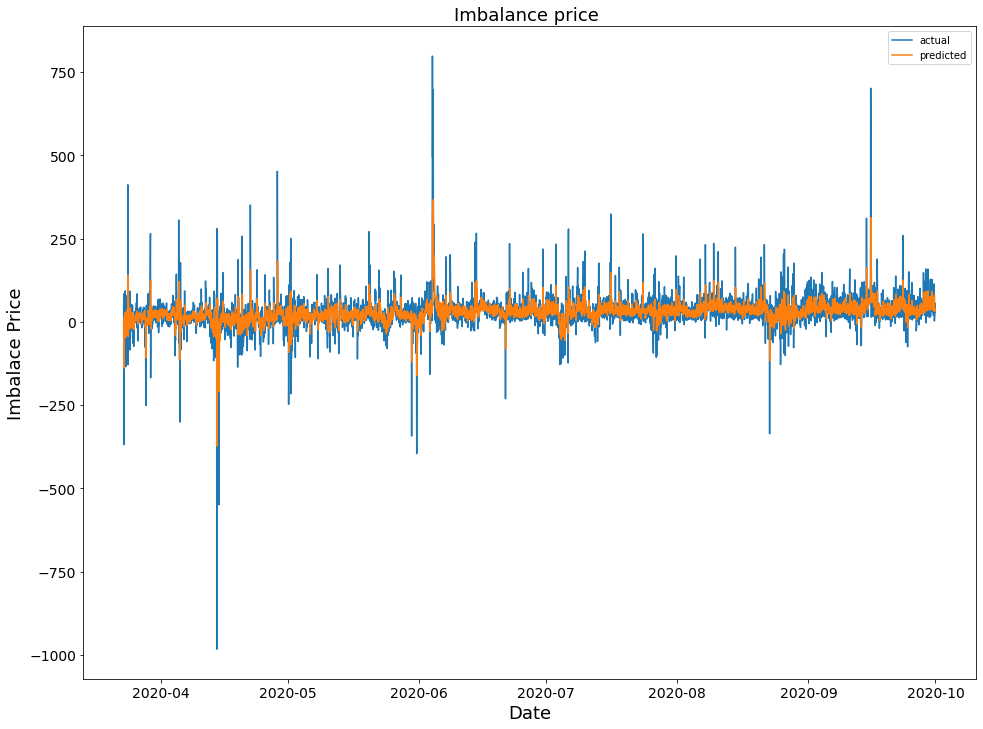

In [189]:
plt.figure(figsize=(16, 12))
#plt.plot(train_2019.iloc[-250:-98], label='train')
plt.plot(forecast_1h_df['imbalance_price_target'], label='actual')
plt.plot(forecast_1h_df['predicted'], label='predicted')
plt.legend()
plt.xlabel('Date', fontsize=18)
plt.ylabel('Imbalace Price', fontsize=18)
plt.title('Imbalance price ', fontsize=18)
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14);
plt.savefig('imb_price_train_test_arima_1h.png')

In [192]:
np.sqrt(mean_squared_error(forecast_1h_df['imbalance_price_target'].values, forecast_1h_df['predicted'].values))

50.22046437427285

In [193]:
len(forecast_1h_df)

4601

In [ ]:
# RMSE
rmse = np.sqrt(mean_squared_error())

In [28]:
#for i in range(len(test_2019)):
forecasts_6h = []
for i in range(0,24,6):
    model_6h = ARIMA(train_2019.iloc[:-(25-i),:], order=(2,1,7))
    model_6h_fit = model_6h.fit()
    forecast_6h = model_6h_fit.forecast(steps=6)
    print(forecast_6h)
    forecasts_6h.append(forecast_6h.values)

2020-08-17 15:00:00    457.938858
2020-08-17 16:00:00    215.031158
2020-08-17 17:00:00    186.804066
2020-08-17 18:00:00    154.360982
2020-08-17 19:00:00    110.536118
2020-08-17 20:00:00    105.468761
Freq: H, Name: predicted_mean, dtype: float64
2020-08-17 21:00:00      7.779984
2020-08-17 22:00:00    125.419474
2020-08-17 23:00:00    131.720098
2020-08-18 00:00:00    108.379550
2020-08-18 01:00:00    120.265317
2020-08-18 02:00:00    121.496040
Freq: H, Name: predicted_mean, dtype: float64
2020-08-18 03:00:00   -12.578646
2020-08-18 04:00:00    26.210504
2020-08-18 05:00:00    48.630590
2020-08-18 06:00:00    75.986324
2020-08-18 07:00:00    80.562780
2020-08-18 08:00:00    82.297769
Freq: H, Name: predicted_mean, dtype: float64
2020-08-18 09:00:00   -142.857622
2020-08-18 10:00:00    -43.296123
2020-08-18 11:00:00    -17.782585
2020-08-18 12:00:00     24.525237
2020-08-18 13:00:00     46.281686
2020-08-18 14:00:00     49.894842
Freq: H, Name: predicted_mean, dtype: float64


In [29]:
forecasts_6h = np.array(forecasts_6h).reshape(24,1)

In [30]:
forecast_6h_df = train_2019.iloc[-25:-1]
forecast_6h_df['predicted'] = np.array(forecasts_6h)

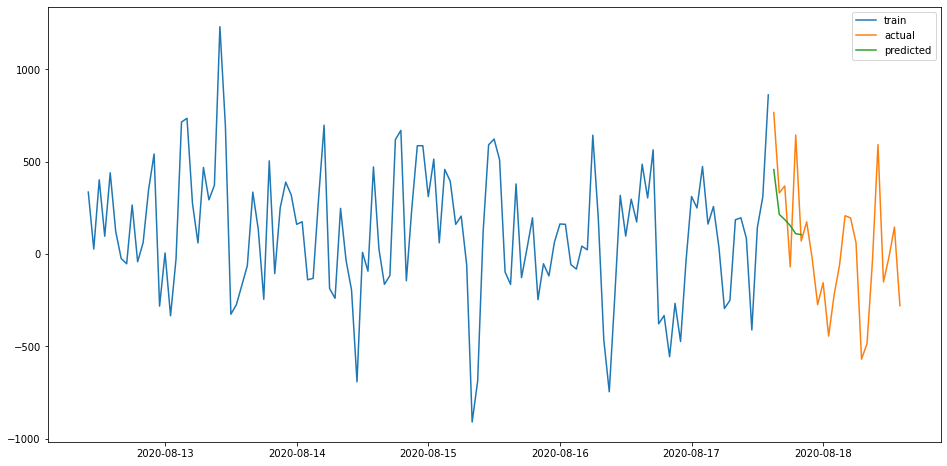

In [31]:
plt.figure(figsize=(16, 8))
plt.plot(train_2019.iloc[-150:-25], label='train')
plt.plot(forecast_6h_df['imbalance_price'], label='actual')
plt.plot(forecast_6h_df['predicted'].iloc[:6], label='predicted')
plt.legend()

Index(['fiftyhertz', 'tennet', 'amprion', 'transnetbw', 'nrv'], dtype='object')

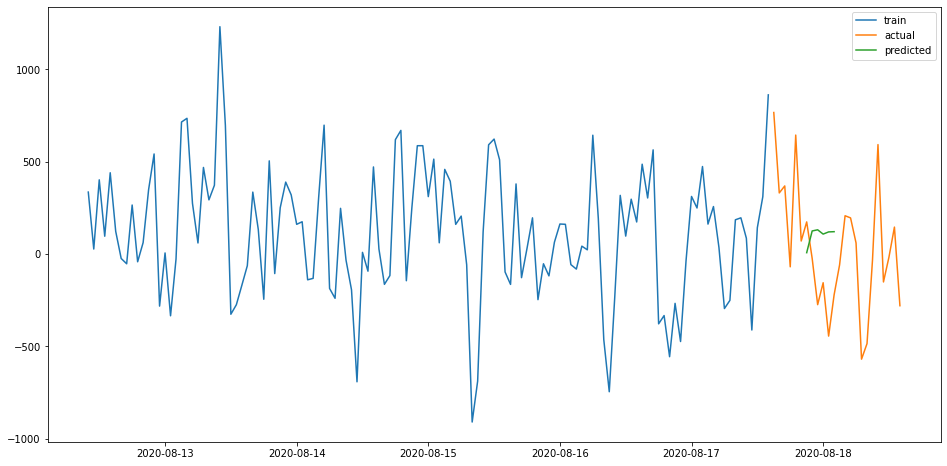

In [32]:
plt.figure(figsize=(16, 8))
plt.plot(train_2019.iloc[-150:-25], label='train')
plt.plot(forecast_6h_df['imbalance_price'], label='actual')
plt.plot(forecast_6h_df['predicted'].iloc[6:12], label='predicted')
plt.legend()

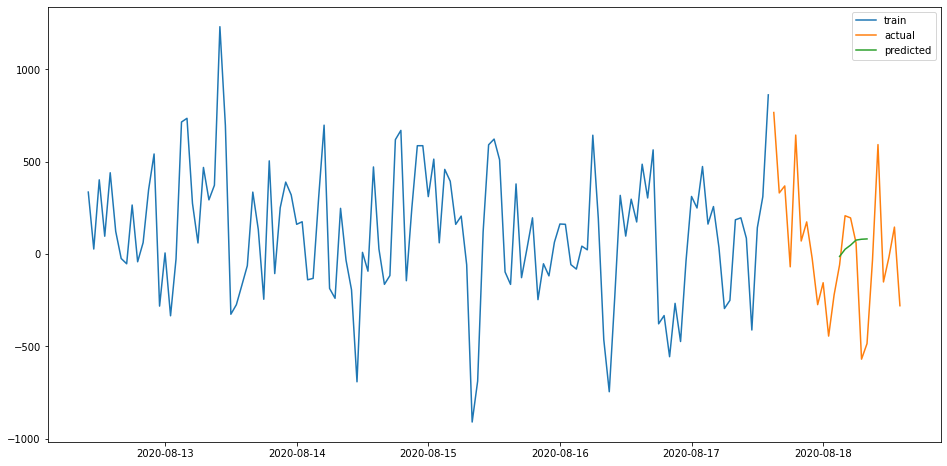

In [33]:
plt.figure(figsize=(16, 8))
plt.plot(train_2019.iloc[-150:-25], label='train')
plt.plot(forecast_6h_df['imbalance_price'], label='actual')
plt.plot(forecast_6h_df['predicted'].iloc[12:18], label='predicted')
plt.legend()

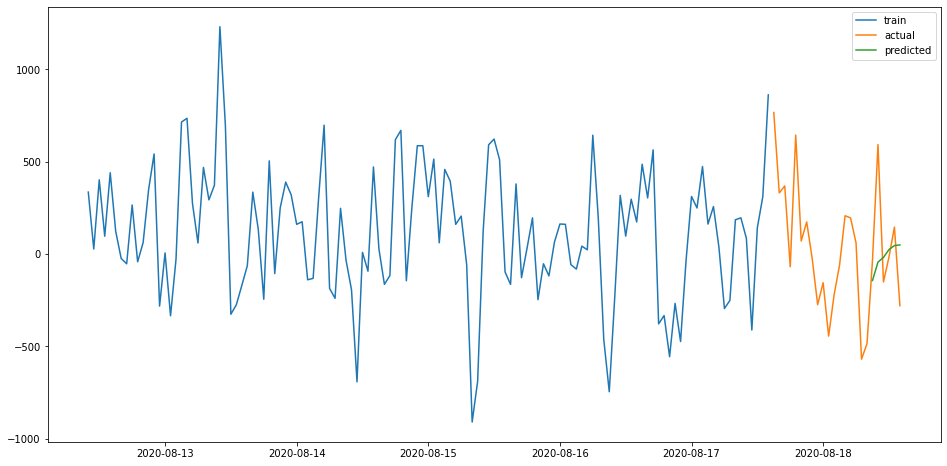

In [34]:
plt.figure(figsize=(16, 8))
plt.plot(train_2019.iloc[-150:-25], label='train')
plt.plot(forecast_6h_df['imbalance_price'], label='actual')
plt.plot(forecast_6h_df['predicted'].iloc[18:], label='predicted')
plt.legend()

In [ ]:
# or parameters of the model (fit_intercept for Linear Regression model)
mlflow_params = {
      "p": fitted_model.params,
      "d": ,
      "q": ,
  }

In [ ]:
# logging params to mlflow
mlflow.log_params(params)
# setting tags
mlflow.set_tag("model", "ARIMA")
mlflow.set_tag("features", "imbalance price")
# logging metrics
mlflow.log_metric("test-" + "RMSE", rmse)
mlflow.log_metric("test-" + "R2", rsquared)
# end run
mlflow.end_run()

In [ ]:
plt.figure(figsize=(14,6))
residuals = pd.DataFrame(model_fit.resid)
plt.plot(residuals, label='residuals')
#plt.plot(train_2019, label= 'original', alpha=0.5)
plt.legend()

## Without outliers

In [139]:
train_2019_nooutlier = train_2019[(train_2019 >= train_2019.quantile(0.05)) & (train_2019 <= train_2019.quantile(0.95))]

In [142]:
train_2019_nooutlier.head()

imbalance_price
timestamp                           
2019-01-01 00:00:00        -329.6045
2019-01-01 01:00:00        -283.8000
2019-01-01 02:00:00        -334.7170
2019-01-01 03:00:00         117.6665
2019-01-01 04:00:00        -323.3150

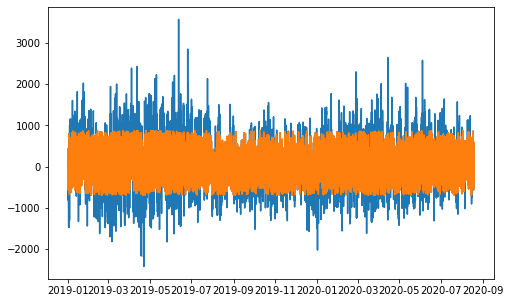

In [166]:
plt.figure(figsize=(8,5))
plt.plot(train_2019)
plt.plot(train_2019_nooutlier)

In [143]:
train_2019_nooutlier = fill_missing(train_2019_nooutlier)

In [144]:
train_2019_nooutlier

imbalance_price
timestamp                           
2019-01-01 00:00:00        -329.6045
2019-01-01 01:00:00        -283.8000
2019-01-01 02:00:00        -334.7170
2019-01-01 03:00:00         117.6665
2019-01-01 04:00:00        -323.3150
...                              ...
2020-08-18 11:00:00        -150.6755
2020-08-18 12:00:00         -16.4735
2020-08-18 13:00:00         146.3290
2020-08-18 14:00:00        -279.3080
2020-08-18 15:00:00         196.7430

[14296 rows x 1 columns]

In [145]:
kpss_test(train_2019_nooutlier)

Results of KPSS Test:
Test Statistic            1.233565
p-value                   0.010000
Lags Used                42.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [146]:
adf_test(train_2019_nooutlier)

Results of Dickey-Fuller Test:
Test Statistic                -1.569009e+01
p-value                        1.437384e-28
#Lags Used                     3.000000e+01
Number of Observations Used    1.426500e+04
Critical Value (1%)           -3.430808e+00
Critical Value (5%)           -2.861743e+00
Critical Value (10%)          -2.566878e+00
dtype: float64


In [149]:
diff_train_2019_nooutlier = take_diff(train_2019_nooutlier)

In [150]:
kpss_test(diff_train_2019_nooutlier)

Results of KPSS Test:
Test Statistic            0.002075
p-value                   0.100000
Lags Used                42.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [151]:
adf_test(diff_train_2019_nooutlier)

Results of Dickey-Fuller Test:
Test Statistic                   -28.716000
p-value                            0.000000
#Lags Used                        42.000000
Number of Observations Used    14252.000000
Critical Value (1%)               -3.430809
Critical Value (5%)               -2.861743
Critical Value (10%)              -2.566878
dtype: float64


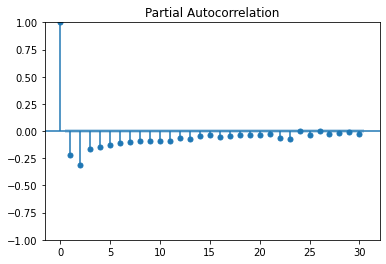

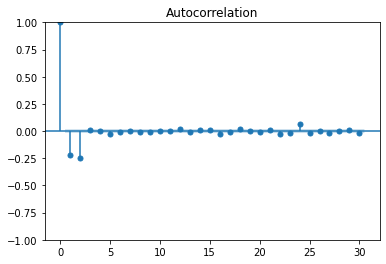

In [152]:
plot_pacf(diff_train_2019, lags=30, alpha=0.05)
plot_acf(diff_train_2019, lags=30, alpha=0.05);

In [156]:
#for i in range(len(test_2019)):
forecasts_1h_nooutlier = []
for i in range(24):
    model_1h_nooutlier = ARIMA(train_2019_nooutlier.iloc[:-(25-i),:], order=(2,1,6))
    model_1h_fit_nooutlier = model_1h_nooutlier.fit()
    forecast_1h_nooutlier = model_1h_fit_nooutlier.forecast(steps=1)
    print(forecast_1h_nooutlier)
    forecasts_1h_nooutlier.append(forecast_1h_nooutlier)

2020-08-17 15:00:00    413.767378
Freq: H, dtype: float64
2020-08-17 16:00:00    344.820749
Freq: H, dtype: float64
2020-08-17 17:00:00    190.612087
Freq: H, dtype: float64
2020-08-17 18:00:00    217.200977
Freq: H, dtype: float64
2020-08-17 19:00:00    21.701165
Freq: H, dtype: float64
2020-08-17 20:00:00    368.968817
Freq: H, dtype: float64
2020-08-17 21:00:00    62.772299
Freq: H, dtype: float64
2020-08-17 22:00:00    180.215036
Freq: H, dtype: float64
2020-08-17 23:00:00    35.936889
Freq: H, dtype: float64
2020-08-18   -32.638875
Freq: H, dtype: float64
2020-08-18 01:00:00    2.062458
Freq: H, dtype: float64
2020-08-18 02:00:00   -135.788368
Freq: H, dtype: float64
2020-08-18 03:00:00   -28.193423
Freq: H, dtype: float64
2020-08-18 04:00:00    10.324714
Freq: H, dtype: float64
2020-08-18 05:00:00    134.084868
Freq: H, dtype: float64
2020-08-18 06:00:00    112.348211
Freq: H, dtype: float64
2020-08-18 07:00:00    65.309703
Freq: H, dtype: float64
2020-08-18 08:00:00   -212.63237

In [158]:
forecast_1h_nooutlier_df = train_2019.iloc[-25:-1]
forecast_1h_nooutlier_df['predicted'] = np.array(forecasts_1h_nooutlier)

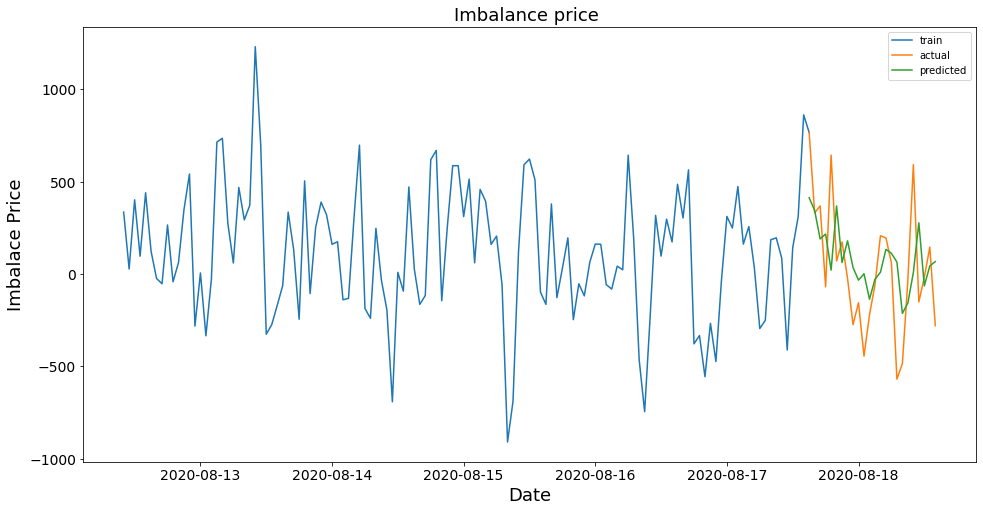

In [159]:
plt.figure(figsize=(16, 8))
plt.plot(train_2019.iloc[-150:-24], label='train')
plt.plot(forecast_1h_nooutlier_df['imbalance_price'], label='actual')
plt.plot(forecast_1h_nooutlier_df['predicted'], label='predicted')
plt.legend()
plt.xlabel('Date', fontsize=18)
plt.ylabel('Imbalace Price', fontsize=18)
plt.title('Imbalance price ', fontsize=18)
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14);


In [161]:
np.sqrt(mean_squared_error(forecast_1h_nooutlier_df['imbalance_price'].values, forecast_1h_nooutlier_df['predicted'].values))

308.3407719901207

## SHORTER DATA

In [179]:
train_2019

imbalance_price
timestamp                           
2019-01-01 00:00:00        -329.6045
2019-01-01 01:00:00        -283.8000
2019-01-01 02:00:00        -334.7170
2019-01-01 03:00:00         117.6665
2019-01-01 04:00:00        -323.3150
...                              ...
2020-08-18 11:00:00        -150.6755
2020-08-18 12:00:00         -16.4735
2020-08-18 13:00:00         146.3290
2020-08-18 14:00:00        -279.3080
2020-08-18 15:00:00         196.7430

[14296 rows x 1 columns]

In [186]:
train_jan = train_2019[(train_2019.index >= '2019-01-01 00:00:00') & (train_2019.index < '2019-02-01 00:00:00')]
train_feb = train_2019[(train_2019.index >= '2019-02-01 00:00:00') & (train_2019.index < '2019-03-01 00:00:00')]
train_june = train_2019[(train_2019.index >= '2019-06-01 00:00:00') & (train_2019.index < '2019-08-01 00:00:00')]
train_sep = train_2019[(train_2019.index >= '2019-09-01 00:00:00') & (train_2019.index < '2019-11-01 00:00:00')]
train_oct = train_2019[(train_2019.index >= '2019-10-01 00:00:00') & (train_2019.index < '2019-12-01 00:00:00')]

In [190]:
kpss_test(train_jan)

Results of KPSS Test:
Test Statistic            0.221805
p-value                   0.100000
Lags Used                20.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [193]:
kpss_test(train_oct)

Results of KPSS Test:
Test Statistic            0.103878
p-value                   0.100000
Lags Used                24.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [192]:
adf_test(train_jan)

Results of Dickey-Fuller Test:
Test Statistic                -9.234495e+00
p-value                        1.644381e-15
#Lags Used                     2.000000e+00
Number of Observations Used    7.410000e+02
Critical Value (1%)           -3.439206e+00
Critical Value (5%)           -2.865448e+00
Critical Value (10%)          -2.568851e+00
dtype: float64


In [194]:
adf_test(train_oct)

Results of Dickey-Fuller Test:
Test Statistic                -1.232007e+01
p-value                        6.782405e-23
#Lags Used                     4.000000e+00
Number of Observations Used    1.459000e+03
Critical Value (1%)           -3.434840e+00
Critical Value (5%)           -2.863523e+00
Critical Value (10%)          -2.567826e+00
dtype: float64


In [198]:
dif_train_jan = take_diff(train_jan)
dif_train_june = take_diff(train_june)

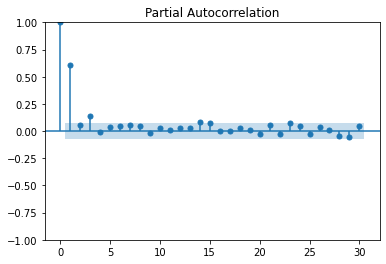

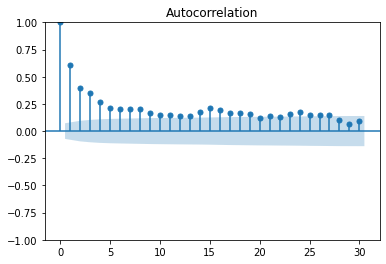

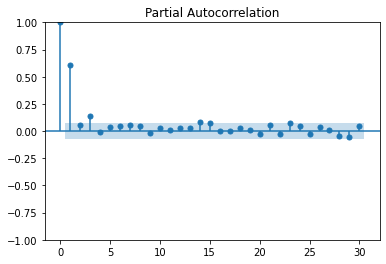

In [236]:
plot_acf(train_jan, lags=30, alpha=0.05)
plot_pacf(train_jan, lags=30, alpha=0.05)

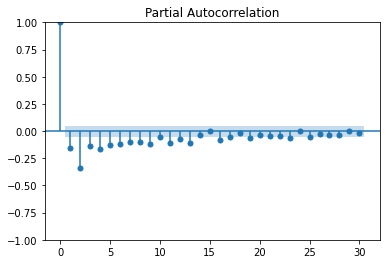

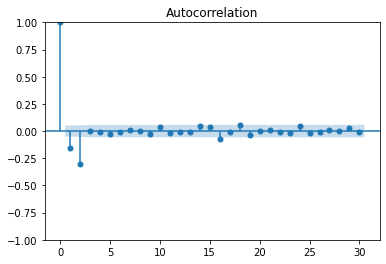

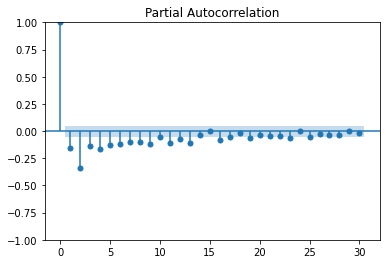

In [199]:
plot_acf(dif_train_june, lags=30, alpha=0.05)
plot_pacf(dif_train_june, lags=30, alpha=0.05)

In [200]:
p_range = range(1,4)
d_range = [1]
q_range = range(1,4)

In [201]:
aic_jan = best_aic(train_jan, p_range, d_range, q_range)


(1, 1, 1) 11055.577832263341
(1, 1, 2) 11057.457718835736
(1, 1, 3) 11054.863367386844
(2, 1, 1) 11057.504953375894
(2, 1, 2) 11056.494818028848
(2, 1, 3) 11054.913106656233
(3, 1, 1) 11053.43501773107
(3, 1, 2) 11054.09639853087
(3, 1, 3) 11055.790833047906


all values of p,d,q more or less provides same aic


In [205]:
forecasts_1h_jan = []
for i in range(24):
    model_1h_jan = ARIMA(train_jan.iloc[:-(25-i),:], order=(1,1,1))
    model_1h_fit_jan = model_1h_jan.fit()
    forecast_1h_jan = model_1h_fit_jan.forecast(steps=1)
    print(forecast_1h_jan)
    forecasts_1h_jan.append(forecast_1h_jan)

2019-01-30 23:00:00    237.438938
Freq: H, dtype: float64
2019-01-31    533.236246
Freq: H, dtype: float64
2019-01-31 01:00:00    314.945466
Freq: H, dtype: float64
2019-01-31 02:00:00    328.583232
Freq: H, dtype: float64
2019-01-31 03:00:00    351.563912
Freq: H, dtype: float64
2019-01-31 04:00:00    286.48941
Freq: H, dtype: float64
2019-01-31 05:00:00    275.06384
Freq: H, dtype: float64
2019-01-31 06:00:00    606.429349
Freq: H, dtype: float64
2019-01-31 07:00:00    404.254345
Freq: H, dtype: float64
2019-01-31 08:00:00    294.272081
Freq: H, dtype: float64
2019-01-31 09:00:00   -287.646844
Freq: H, dtype: float64
2019-01-31 10:00:00    148.519254
Freq: H, dtype: float64
2019-01-31 11:00:00    252.226136
Freq: H, dtype: float64
2019-01-31 12:00:00    242.970699
Freq: H, dtype: float64
2019-01-31 13:00:00   -100.481019
Freq: H, dtype: float64
2019-01-31 14:00:00   -123.27056
Freq: H, dtype: float64
2019-01-31 15:00:00    693.460748
Freq: H, dtype: float64
2019-01-31 16:00:00    852

In [221]:
forecasts_1h_jan

[2019-01-30 23:00:00    237.438938
 Freq: H, dtype: float64,
 2019-01-31    533.236246
 Freq: H, dtype: float64,
 2019-01-31 01:00:00    314.945466
 Freq: H, dtype: float64,
 2019-01-31 02:00:00    328.583232
 Freq: H, dtype: float64,
 2019-01-31 03:00:00    351.563912
 Freq: H, dtype: float64,
 2019-01-31 04:00:00    286.48941
 Freq: H, dtype: float64,
 2019-01-31 05:00:00    275.06384
 Freq: H, dtype: float64,
 2019-01-31 06:00:00    606.429349
 Freq: H, dtype: float64,
 2019-01-31 07:00:00    404.254345
 Freq: H, dtype: float64,
 2019-01-31 08:00:00    294.272081
 Freq: H, dtype: float64,
 2019-01-31 09:00:00   -287.646844
 Freq: H, dtype: float64,
 2019-01-31 10:00:00    148.519254
 Freq: H, dtype: float64,
 2019-01-31 11:00:00    252.226136
 Freq: H, dtype: float64,
 2019-01-31 12:00:00    242.970699
 Freq: H, dtype: float64,
 2019-01-31 13:00:00   -100.481019
 Freq: H, dtype: float64,
 2019-01-31 14:00:00   -123.27056
 Freq: H, dtype: float64,
 2019-01-31 15:00:00    693.460748
 

In [225]:
def plot_forecast(train_df, forecast_list):
    forecast_df = train_df.iloc[-25:-1]
    forecast_df['predicted'] = np.array(forecast_list)
    print(forecast_df)

In [232]:
def plot_forecast(train_df, forecast_list):
    forecast_df = train_df.iloc[-25:-1]
    forecast_df['predicted'] = np.array(forecast_list)
    #print(forecast_df)

    #ploting
    plt.figure(figsize=(16, 8))
    plt.plot(train_df.iloc[-150:-24], label='train')
    plt.plot(forecast_df['imbalance_price'], label='actual')
    plt.plot(forecast_df['predicted'], label='predicted')
    plt.legend()
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Imbalace Price', fontsize=18)
    plt.title('Imbalance price ', fontsize=18)
    plt.xticks(fontsize= 14)
    plt.yticks(fontsize= 14)
    mse =mean_squared_error(forecast_df['imbalance_price'].values, forecast_df['predicted'].values)
    print('rmse = ', np.sqrt(mse));

rmse =  463.9450344170957


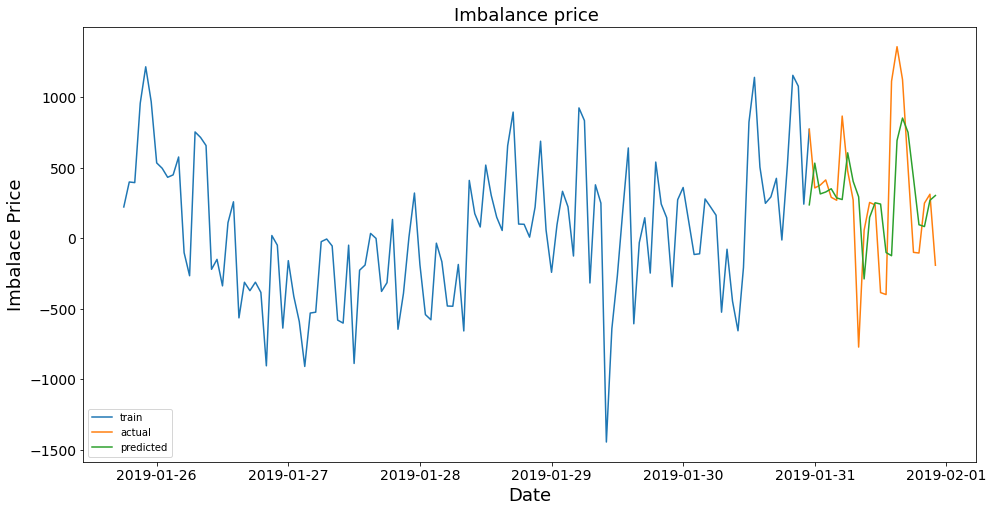

In [233]:
plot_forecast(train_jan,  forecasts_1h_jan)

In [203]:
aic_jun = best_aic(train_june, p_range, d_range, q_range)

(1, 1, 1) 22128.92797987238
(1, 1, 2) 22089.745905851956
(1, 1, 3) 22096.0832110964
(2, 1, 1) 22104.727758684814
(2, 1, 2) 22089.272992844883
(2, 1, 3) 22092.992132836207
(3, 1, 1) 22087.60115253723
(3, 1, 2) 22088.12102178006
(3, 1, 3) 22092.201768152583


1,1,2 could be selected as the best values for p,d,q respectively 

In [206]:
forecasts_1h_june = []
for i in range(24):
    model_1h_june = ARIMA(train_june.iloc[:-(25-i),:], order=(1,1,2))
    model_1h_fit_june = model_1h_june.fit()
    forecast_1h_june = model_1h_fit_june.forecast(steps=1)
    print(forecast_1h_june)
    forecasts_1h_june.append(forecast_1h_june)

2019-07-30 23:00:00   -137.970909
Freq: H, dtype: float64
2019-07-31   -96.261106
Freq: H, dtype: float64
2019-07-31 01:00:00   -1.91021
Freq: H, dtype: float64
2019-07-31 02:00:00   -225.891652
Freq: H, dtype: float64
2019-07-31 03:00:00   -64.85471
Freq: H, dtype: float64
2019-07-31 04:00:00    4.778478
Freq: H, dtype: float64
2019-07-31 05:00:00   -338.306357
Freq: H, dtype: float64
2019-07-31 06:00:00   -211.352263
Freq: H, dtype: float64
2019-07-31 07:00:00   -72.346669
Freq: H, dtype: float64
2019-07-31 08:00:00   -31.265422
Freq: H, dtype: float64
2019-07-31 09:00:00   -419.480241
Freq: H, dtype: float64
2019-07-31 10:00:00    241.727187
Freq: H, dtype: float64
2019-07-31 11:00:00   -49.365468
Freq: H, dtype: float64
2019-07-31 12:00:00   -273.879919
Freq: H, dtype: float64
2019-07-31 13:00:00   -433.212419
Freq: H, dtype: float64
2019-07-31 14:00:00   -301.582006
Freq: H, dtype: float64
2019-07-31 15:00:00   -119.556753
Freq: H, dtype: float64
2019-07-31 16:00:00   -127.969346


rmse =  499.5747031426609


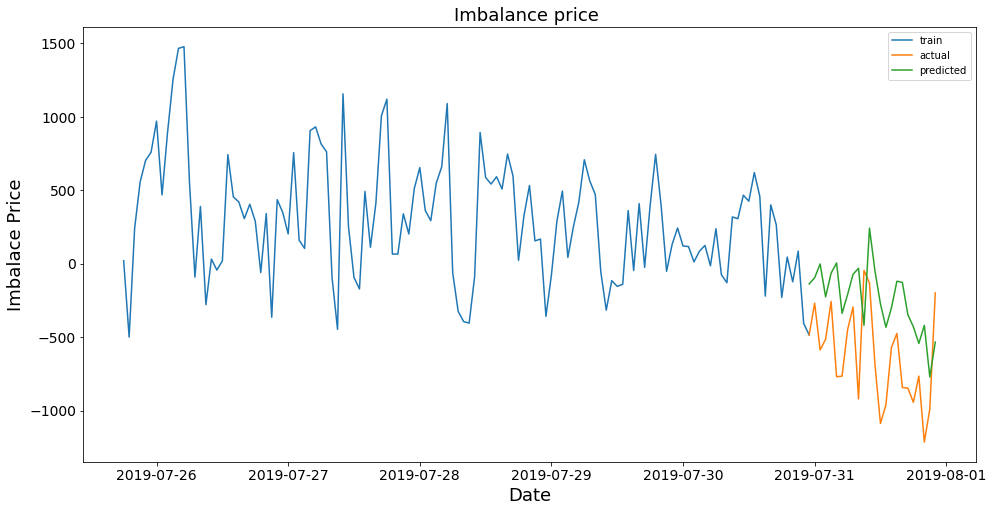

In [234]:
plot_forecast(train_june,  forecasts_1h_june)

In [204]:
aic_sep = best_aic(train_sep, p_range, d_range, q_range)

(1, 1, 1) 21364.138999860428
(1, 1, 2) 21352.742411707306
(1, 1, 3) 21354.052205521963
(2, 1, 1) 21361.085414714504
(2, 1, 2) 21350.092184739904
(2, 1, 3) 21340.92892678044
(3, 1, 1) 21340.815614810188
(3, 1, 2) 21342.479233996954
(3, 1, 3) 21342.96056297978


best parameters : 2,1,3

In [207]:
forecasts_1h_sep = []
for i in range(24):
    model_1h_sep = ARIMA(train_sep.iloc[:-(25-i),:], order=(2,1,3))
    model_1h_fit_sep = model_1h_sep.fit()
    forecast_1h_sep = model_1h_fit_sep.forecast(steps=1)
    print(forecast_1h_sep)
    forecasts_1h_sep.append(forecast_1h_sep)

2019-10-30 23:00:00   -8.699789
Freq: H, dtype: float64
2019-10-31    147.048144
Freq: H, dtype: float64
2019-10-31 01:00:00    131.49213
Freq: H, dtype: float64
2019-10-31 02:00:00    109.386027
Freq: H, dtype: float64
2019-10-31 03:00:00    81.338464
Freq: H, dtype: float64
2019-10-31 04:00:00    41.356263
Freq: H, dtype: float64
2019-10-31 05:00:00   -10.294113
Freq: H, dtype: float64
2019-10-31 06:00:00   -41.558671
Freq: H, dtype: float64
2019-10-31 07:00:00   -55.251596
Freq: H, dtype: float64
2019-10-31 08:00:00    110.626009
Freq: H, dtype: float64
2019-10-31 09:00:00   -14.039709
Freq: H, dtype: float64
2019-10-31 10:00:00   -156.127926
Freq: H, dtype: float64
2019-10-31 11:00:00   -195.875361
Freq: H, dtype: float64
2019-10-31 12:00:00   -269.730576
Freq: H, dtype: float64
2019-10-31 13:00:00   -71.737084
Freq: H, dtype: float64
2019-10-31 14:00:00   -38.008621
Freq: H, dtype: float64
2019-10-31 15:00:00   -126.025412
Freq: H, dtype: float64
2019-10-31 16:00:00   -71.130381
F

rmse =  372.00844408927736


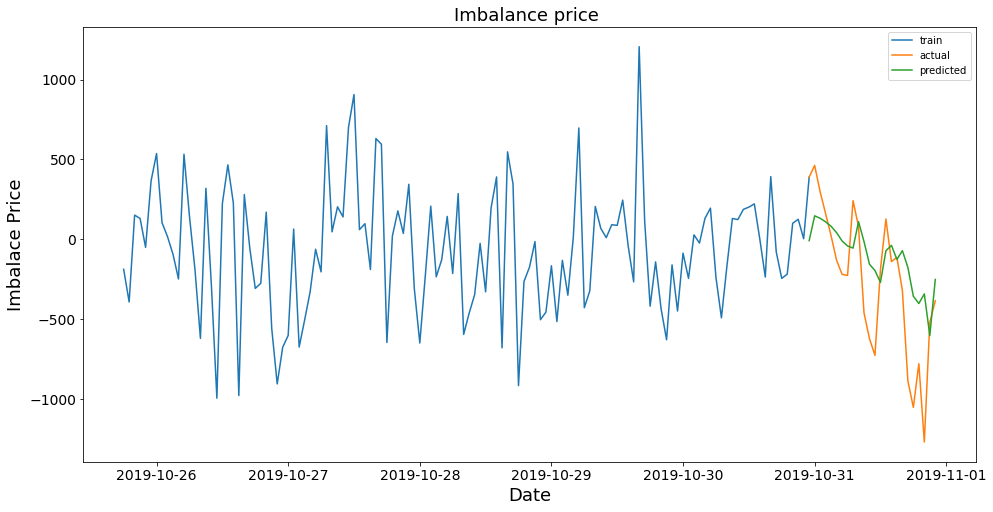

In [235]:
plot_forecast(train_sep,  forecasts_1h_sep)